## Introduction
### Goal

### Background

#### Time Series Models and Recurrent Neural Network (RNN)

Time series models are probabilistic models over a sequence of hidden states (hidden variables) $z_{1:T}$ and observations $x_{1:T}$.

A time series model is characterized by an initial distribution $\nu(z_1)$, a series
of transition distributions $f_{t}(z_t|z_{1:t−1}, x_{1:t−1})$, and a series of emission distributions $g_{t}(x_t|z_{1:t}, x_{1:t})$ with the joint distribution being $p(z_{1:T}, x_{1:T}) = \nu(z_1) \prod_{t=2}^T f_{t}(z_t|z_{1:t−1}, x_{1:t−1}) \prod_{t=1}^T g_{t}(x_t|z_{1:t}, x_{1:t})$.

One simplification of time series model is the Hidden Markov Model (HMM) which is shown below. For HMM, transition distributions are simplified to $f(z_t|z_{t−1})$ and emission distributions to $g(x_t|z_t)$ with the joint $p(z_{1:T}, x_{1:T}) = \nu(z_1) \prod_{t=2}^T f(z_t|z_{t−1}) \prod_{t=1}^T g(x_t|z_t)$.


<img src="doc_imgs/hmm.png" alt="Drawing" style="width: 500px"/>


An popular tool to solve time series probelm is Recurrent Neural Network (RNN). An RNN can take a sequence of variables $v_{1:T}$ as input by recusively process each variable while maintaing its internal hidden state $h$. At each timestep $t$, the RNN take $v_t$ and update its hidden states $h_t$ by:

$$h_t = u(v_t, h_{t-1}),$$

where $u$ is a deterministic non-linear function. Before taking any input, the initial hidden state of RNN $h_0$ is usually set as all 0.

#### Variational Auto-Encoder (VAE)
In many cases, the transition distribution $f$ and emission distribution $g$ are unknown, and we want to learn them from observations. One important idea supporting us to do is Variational Auto-Encoders (VAE) [[kingma2013](https://arxiv.org/abs/1312.6114)].

<img src="doc_imgs/vae.png" alt="Drawing" style="width: 500px"/>

The image reference: [[vae_img](https://blog.shazam.com/learning-to-understand-music-from-shazam-56a60788b62f)]

A VAE jointly models the generative process from hidden variables $z$ to data $x$, and the recognition process from observed data $x$ to hidden variables $z$, using two distinct neural networks. The recoginition network $q_\phi(z|x^{(i)})$, also called encoder, derives a distribution over possible values of $z$ to approximate the posterior $p(z|x)$, given an observed datapoint $x^{(i)}$. The generative network $p_\theta(x|z)$, also called decoder, generates a distribution over possible values of $x$ given hidden variables $z$. $\theta$ and $\phi$ are parameters of generative networks and recoginition networks seperately, and they are learned by optimizing Evidence Lower Bound (ELBO):


<img src="doc_imgs/VAE_ELBO.png" alt="Drawing" style="width: 350px"/>


As you may notice, the ELBO of VAE is quite close to the one in the lecture about Variation Inference, expect that $q(z)$ is changed to $q_\phi(z|x)$.

#### Variational Recurrent Neural Network (VRNN)
Finally, we move to the core idea behind this project, Variational Recurrent Neural Network (VRNN) [[chung2015recurrent](https://arxiv.org/abs/1506.02216)]. The VRNN contains a VAE at every timestep, but the VAEs are conditioned on the internal state variable $h_{t-1}$ of an RNN. This will help the VAE to take into account the temporal relationship in sequential data. In our project, long short-term memory (LSTM) is used as the RNN model.


The VRNN contains following operations, and the following image is an illustration of them:
* prior: $z_t \sim \mathcal{N}(\mu_{prior,t}, \text{diag}(\sigma_{prior,t}^2))$, where $[\mu_{prior,t}, \sigma_{prior,t}]=\varphi^{prior}(h_{t-1})$
* recognition (encoder): $z_t|x_t \sim \mathcal{N}(\mu_{enc,t}, \text{diag}(\sigma_{enc,t}^2))$, where $[\mu_{enc,t}, \sigma_{enc,t}]=\varphi^{enc}(\varphi^{x}(x_t), h_{t-1})$
* generation (decoder): $x_t|z_t \sim \mathcal{N}(\mu_{dec,t}, \text{diag}(\sigma_{dec,t}^2))$, where $[\mu_{dec,t}, \sigma_{dec,t}]=\varphi^{dec}(\varphi^{z}(z_t), h_{t-1})$
* feature extraction from $x_t$ and $z_t$, respectively: $\varphi^{x}$ and $\varphi^{z}$
* RNN update: $h_t=u(\varphi^{x}(x_t), \varphi^{z}(z_t), h_{t-1})$
<br><br><br>


<img src="doc_imgs/VRNN.png" alt="Drawing" style="width: 1400px"/>
<br><br><br>

Again, the parameters in all network are learned by optimizing following ELBO:

<img src="doc_imgs/VRNN_ELBO.png" alt="Drawing" style="width: 700px"/>

From above, the VRNN can learn the transition distribution $f_{t}(z_t|z_{1:t−1}, x_{1:t−1})$ as the prior network $\varphi^{prior}$ and emission distribution $g_{t}(x_t|z_{1:t}, x_{1:t−1})$ as the generation network $\varphi^{dec}$. With $f$ and $g$, given $x_{1:t}$, we can make 1-step prediction $x_{t+1}$ as follows:

$$\tilde{z}_{t+1} \sim f_{t+1}(z_{t+1}|z_{1:t}, x_{1:t}) = \varphi^{prior}(h_{t})$$
$$\tilde{x}_{t+1} \sim g_{t+1}(x_{t+1}|[z_{1:t}, \tilde{z}_{t+1}], x_{1:t}) = \varphi^{dec}(\varphi^{z}(\tilde{z}_{t+1}), h_{t})$$
$$\tilde{h}_{t+1} = u(\varphi^{x}(\tilde{x}_{t+1}), \varphi^{z}(\tilde{z}_{t+1}), h_{t})$$

**In our project, we made 1-step prediction as above at every timestep and obtained predicted observation $\tilde{x}_{1:T}$.** <br>
One can also make $k$-step prediction by repeating the above procedures $k$ times. But as you can imagine, the prediction will become worse as steps increase.

### Data

## Observation Prediction using VRNN

To test the ability of VRNN to make accurate predictions, we conducted experiments with both simulation data and stock data. <br>
The simulation data are generated from 3 different sets of $f$ and $g$, from simple linear ones to complicated non-linear ones, and we will introduce them in the **Experiment** part. <br>
Since each experiment has its own $f$ and $g$ and requires to train a seperate VRNN model, it will take too long if the notebook runs all experiments (7 in total for VRNN). Hence, we will only show the following experiment, and results of other experiments are shown with presaved plots.

**To run the next experiment, please restart the ipython kernel. Otherwise, conflicts in tf graph might happen.**

In [1]:
import numpy as np
import tensorflow as tf
import sys
import os
codebase = '../'
sys.path.append(codebase)

When using Python 3.6.2, the following import from files may throw some warnings because of bugs in Python. Other versions of Python may experience the same issue. It is okay just to ignore the warnings.

In [2]:
from model import VRNNCell, VRNN_model
from data import get_stock_data
from sampler import create_train_test_dataset
from transformation import fhn, linear, lorenz
from distribution import dirac_delta, mvn
from trainer import trainer
from result_saving import create_RLT_DIR
from result_saving import plot_training, plot_training_2d
from result_saving import plot_loss_MSE
from result_saving import plot_hidden, plot_expression
from result_saving import plot_hidden_2d

D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, fa

First, define some hyperparameters and create the directory to store results.

In [3]:
time = 100                    # num of time steps
n_particles = 1               # when == 1 use VAE, when > 1 use Importance Weight AutoEncoder,
                              # will be introduced later
batch_size = 16

lr = 1e-4
epoch = 50

n_train = 50 * batch_size
n_test = 1 * batch_size

Dx = 1                        # dimension of the observation
Dz = 2                        # dimension of the hidden states
Dh = 100                      # dimension of the LSTM state used in VRNN

initial_state_all_zero = True # whether the LSTM state used in VRNN use zero_state as initial state

rslt_dir_name = "fhn"         # the results will be stored in 
                              # VRNN/final-project/results/"rslt_dir_name"/"some_name_depends_on_experiment_params"

experiment_params = {"time": time,
                     "n_particles": n_particles,
                     "batch_size": batch_size,
                     "lr": lr,
                     "epoch": epoch,
                     "initial_state_all_zero": initial_state_all_zero,
                     "rslt_dir_name": rslt_dir_name}
RLT_DIR = create_RLT_DIR(experiment_params)

Then generate the data set for training with simulation.<br>

In the simulation, we use the following setup: <br>
Hidden state $z_t$ are 2D. <br>
Observation $x_t$ are 1D. <br>
transition distributions $f(z_t|z_{t-1})$: use [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model), and it is deterministic<br> 
emission distributions $g(x_t|z_t)$: $\mathcal{N}(Bz_t, \Sigma)$, i.e., apply some linear transformation $B$ to hidden states $z_t$ with gaussian noise.<br>
initial distribution $\nu(z_1)$: $\text{Uniform}(-3,3)$ for each dimension of hidden states.

In [4]:
# transition function
fhn_params = (1.0, 0.95, 0.05, 1.0, 0.15)
f_sample_tran = fhn.fhn_transformation(fhn_params)
f_sample_dist = dirac_delta.dirac_delta(f_sample_tran)

# emission function
linear_params = np.array([[0, 1]])
g_sample_tran = linear.linear_transformation(linear_params)
mvn_sigma = 0.2 * np.eye(1)
g_sample_dist = mvn.mvn(g_sample_tran, mvn_sigma)

# create data set
dataset = create_train_test_dataset(
    n_train=n_train,
    n_test=n_test,
    time=time,
    Dz=Dz,
    Dx=Dx,
    f=f_sample_dist,
    g=g_sample_dist,
    z_0=None,
    lb=-3,
    ub=3)
hidden_train, obs_train, hidden_test, obs_test = dataset

For the model, the VRNN cell uses a 2-layer multilayer perceptron (MLP) for prior, 2-layer MLP for recogition, 2-layer MLP for generation, 2-layer MLP for feature extraction of observation, and 2-layer MLP for feature extraction of hidden states.

In [5]:
myVRNNCell = VRNNCell(Dx=Dx,
                      Dh=Dh,
                      Dz=Dz,
                      batch_size=batch_size,
                      n_particles=n_particles,
                      x_ft_Dhs=[100],
                      z_ft_Dhs=[100],
                      prior_Dhs=[100],
                      enc_Dhs=[100],
                      dec_Dhs=[100])
model = VRNN_model(myVRNNCell,
                   initial_state_all_zero=initial_state_all_zero,
                   is_lstm_Dh=50,
                   sigma_min=1e-3)

In [6]:
mytrainer = trainer(model)
mytrainer.set_result_saving(RLT_DIR, save_freq=10, saving_num=batch_size)
mytrainer.set_data_set(hidden_train, obs_train, hidden_test, obs_test)

Next, we train the VRNN model with the generated dataset, it will print the loss (ELBO) and the MSE between true observation and predicted observation

iter    0, train loss: -2.287, test loss: -2.276, train MSE:  2.847934, test MSE:  2.826107
iter    5, train loss: -0.850, test loss: -0.863, train MSE:  0.339765, test MSE:  0.353439
iter   10, train loss: -0.678, test loss: -0.687, train MSE:  0.223870, test MSE:  0.231968
iter   15, train loss: -0.652, test loss: -0.665, train MSE:  0.215517, test MSE:  0.221386
iter   20, train loss: -0.635, test loss: -0.654, train MSE:  0.208211, test MSE:  0.213210
iter   25, train loss: -0.627, test loss: -0.639, train MSE:  0.204829, test MSE:  0.210187
iter   30, train loss: -0.625, test loss: -0.640, train MSE:  0.204291, test MSE:  0.210088
iter   35, train loss: -0.620, test loss: -0.636, train MSE:  0.202261, test MSE:  0.207808
iter   40, train loss: -0.622, test loss: -0.637, train MSE:  0.203020, test MSE:  0.207992
iter   45, train loss: -0.626, test loss: -0.636, train MSE:  0.204314, test MSE:  0.208652
iter   50, train loss: -0.615, test loss: -0.627, train MSE:  0.200172, test MSE

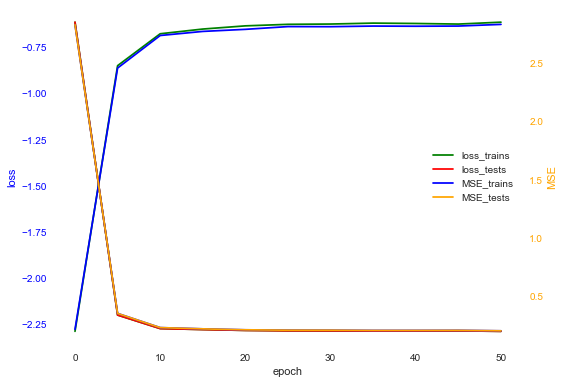

In [7]:
metrics, hidden_val, prediction_val = mytrainer.train(lr=lr,
                                                      epoch=epoch,
                                                      print_freq=5)

loss_trains, loss_tests, MSE_trains, MSE_tests = metrics
hidden_val_train, hidden_val_test = hidden_val
prediction_val_train, prediction_val_test = prediction_val

plot_loss_MSE(RLT_DIR, loss_trains, loss_tests, MSE_trains, MSE_tests, print_freq=5, show=True)

To evaluate the model, we let the model make 1-step prediction of the observation and check if the predicted observation is close to true observation.

The following is the true hidden states (2D) and the true observaion (1D) generated from simulation.

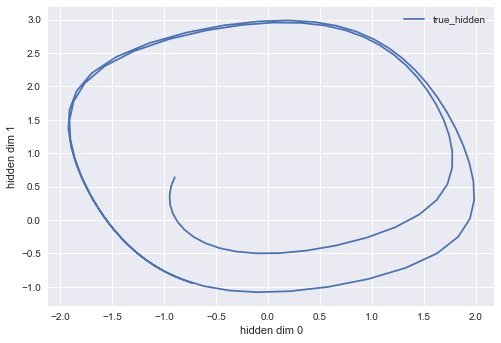

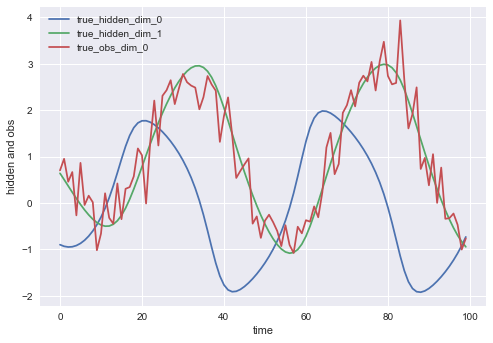

In [8]:
plot_training_2d(RLT_DIR,
                 hidden_test[0:1],
                 is_test=True,
                 show=True)
plot_training(RLT_DIR,
              hidden_test[0:1],
              obs_test[0:1],
              is_test=True,
              show=True)

The following is the comparison between the predicted observation and true observation:

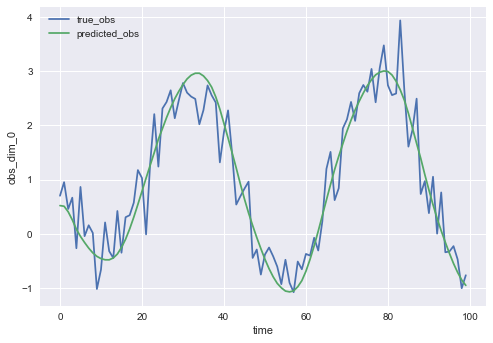

In [9]:
plot_expression(RLT_DIR,
                np.mean(prediction_val_test, axis=2)[0:1],
                obs_test[0:1],
                is_test=True,
                show=True)

From this plot, we can see the VRNN can make close and accurate prediction of observation. <br>
Also from $MSE_{train}=0.202$ and $MSE_{test}=0.193$ in the final epoch, we can see that the prediction errors are almost minimized to $MSE_{true}=0.2$.

## Experiments
The followings are experiments results shown with presaved plots.

### Linear

### FHN

### Lorenz

### Stock
Finally, we applied the VRNN model to the stock data, we tested on [Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).
Here, the transition distribution $f$, emission distribution $g$ and initial state distribution $\nu$ are unknown. <br>
The hidden spaces are also unknown. <br>
The observation space are 5D, which are Open, Hight, Low, Close and Adjused Close.

Instead of simulation, the data set is generated by randomly selecting samples from the stock data in the last 10 years.<br>
Besides, to make training easier, we scaled the stock index by their average value so that the observation values are mostly around 1 rather than something around 10000.

Since we cannot compare hidden states, we can only compare the 1-step observation prediction from VRNN model and true observation.

The loss and MSE during training is:<br>
<img src="experiments/dow_jones/True_1/loss_and_MSE.png" alt="Drawing" style="width: 300px"/>

The follwing plots are some comparisons between predicted observation and true observation: <br>
Note that since the Dow Jones index won't change dramatically most of the time, all 5 dimensions of observation are quite close. To save time and the place of notebook, we just show 2 of them Open and Adjusted Close below. <br>

<table>
<tr>
<td> <img src="experiments/dow_jones/True_1/obs_compare_test/obs_dim_0_idx_1.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/dow_jones/True_1/obs_compare_test/obs_dim_0_idx_2.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/dow_jones/True_1/obs_compare_test/obs_dim_0_idx_3.png" alt="Drawing" style="width: 300px;"/> </td>
</tr>
<td> <img src="experiments/dow_jones/True_1/obs_compare_test/obs_dim_4_idx_1.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/dow_jones/True_1/obs_compare_test/obs_dim_4_idx_2.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/dow_jones/True_1/obs_compare_test/obs_dim_4_idx_3.png" alt="Drawing" style="width: 300px;"/> </td>
</table>

<br>
**As one may notice, the prediction of stock index is close to the true values most of the time, except for the prediction at the beginning.**<br>
As a quantitative evaluation, the final MSE between predicted observation and true observation is 0.00111 on testing dataset, which means:
* for 62% of the time, the prediction error in stock price change will be < 1%.
* for 86% of the time, the prediction error in stock price change will be < 2%.

The initial prediction is poor because the initial state of VRNN is set as all 0. There may be some way to fix it.

## Learn Initial State with the Bidirectional RNN
As argued before, before the RNN takes any inputs, its hidden state $h_0$ is usually set as all 0. It means the initial distribution $\nu$ is not learnable and set to some constant values. As a result, the VRNN has poor performance in the beginning. <br>
[[sussillo2016lfads](https://arxiv.org/abs/1608.06315)] proposed a solution, i.e., learning the initial distribution $\nu$ with the bidirectional RNN with observations as input, shown as below:

<img src="doc_imgs/lfads.png" alt="Drawing" style="width: 700px"/>

Then it samples an initial state from $\nu(z_1)$ and continue with an architecture similar to VRNN to infer the hidden states $z_{1:T}$. <br>
Notice that it uses all observations $x_{1:T}$ when calculating $\nu(z_1)$, it would be cheating if our project applies the same method, because all predictions are already seen by the model before the model predicts them. So we modified the method and only use first half of observation $x_{1:T/2}$ as the input of the bidirectional RNN, shown as follows. In this way, the second half of observations $x_{T/2:T}$ are not seen by the model and it will predict them.

<img src="doc_imgs/half_lfads.png" alt="Drawing" style="width: 700px"/>

**To run the next experiment, please restart the ipython kernel. Otherwise, conflicts in tf graph might happen.**

In [1]:
import numpy as np
import tensorflow as tf
import sys
import os
codebase = '../'
sys.path.append(codebase)

In [2]:
from model import VRNNCell, VRNN_model
from data import get_stock_data
from sampler import create_train_test_dataset
from transformation import fhn, linear, lorenz
from distribution import dirac_delta, mvn
from trainer import trainer
from result_saving import create_RLT_DIR
from result_saving import plot_training, plot_training_2d
from result_saving import plot_loss_MSE
from result_saving import plot_hidden, plot_expression

D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, fa

The changes in hyperparameter are
* ```initial_state_all_zero``` changes from ```False``` to ```True```.
* ```Dz``` increases from ```5``` to ```50```.

In [3]:
time = 100                     # num of time steps
n_particles = 1                # when == 1 use VAE, when > 1 use Importance Weight AutoEncoder,
                               # will be introduced later
batch_size = 16

lr = 1e-4
epoch = 50

n_train = 50 * batch_size
n_test = 1 * batch_size

Dx = 5                         # dimension of the observation
Dz = 50                        # dimension of the hidden states
Dh = 100                       # dimension of the LSTM state used in VRNN

initial_state_all_zero = False # whether the LSTM state used in VRNN use zero_state as initial state

rslt_dir_name = "dow_jones"    # the results will be stored in 
                               # VRNN/final-project/results/"rslt_dir_name"/"some_name_depends_on_experiment_params"

experiment_params = {"time": time,
                     "n_particles": n_particles,
                     "batch_size": batch_size,
                     "lr": lr,
                     "epoch": epoch,
                     "initial_state_all_zero": initial_state_all_zero,
                     "rslt_dir_name": rslt_dir_name}
RLT_DIR = create_RLT_DIR(experiment_params)

Next, we get training and testing dataset from data files. Hidden states are unknown and set to ```None```.

In [4]:
obs_train, obs_test = get_stock_data("dow_jones", time, n_train, n_test, Dx)
hidden_train = hidden_test = None

The model gets more complex with more layers in all networks.

In [5]:
myVRNNCell = VRNNCell(Dx=Dx,
                      Dh=Dh,
                      Dz=Dz,
                      batch_size=batch_size,
                      n_particles=n_particles,
                      x_ft_Dhs=[100, 100],
                      z_ft_Dhs=[100, 100],
                      prior_Dhs=[100, 100, 100],
                      enc_Dhs=[100, 100, 100],
                      dec_Dhs=[100, 100, 100])
model = VRNN_model(myVRNNCell,
                   initial_state_all_zero=initial_state_all_zero,
                   is_lstm_Dh=50,
                   sigma_min=1e-3)

In [6]:
mytrainer = trainer(model)
mytrainer.set_result_saving(RLT_DIR, save_freq=10, saving_num=batch_size)
mytrainer.set_data_set(hidden_train, obs_train, hidden_test, obs_test)

iter    0, train loss: -7.529, test loss: -8.392, train MSE:  1.088173, test MSE:  1.455707
iter    5, train loss:  5.757, test loss:  5.503, train MSE:  0.008177, test MSE:  0.009007
iter   10, train loss: 10.327, test loss: 10.201, train MSE:  0.000858, test MSE:  0.000916
iter   15, train loss: 12.090, test loss: 11.985, train MSE:  0.000383, test MSE:  0.000443
iter   20, train loss: 13.373, test loss: 13.088, train MSE:  0.000277, test MSE:  0.000357
iter   25, train loss: 13.659, test loss: 13.455, train MSE:  0.000241, test MSE:  0.000276
iter   30, train loss: 13.235, test loss: 13.082, train MSE:  0.000289, test MSE:  0.000314
iter   35, train loss: 13.864, test loss: 13.720, train MSE:  0.000233, test MSE:  0.000253
iter   40, train loss: 14.169, test loss: 14.082, train MSE:  0.000210, test MSE:  0.000242
iter   45, train loss: 13.947, test loss: 13.869, train MSE:  0.000224, test MSE:  0.000242
iter   50, train loss: 14.500, test loss: 14.373, train MSE:  0.000188, test MSE

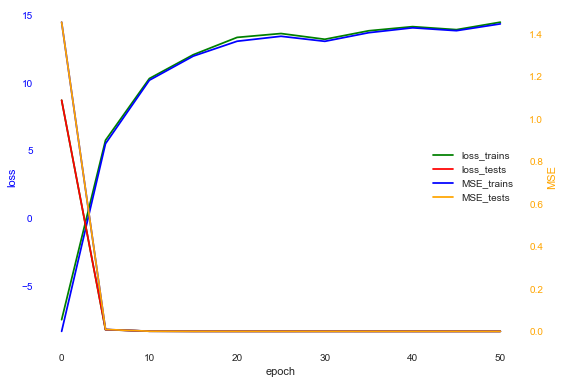

In [7]:
metrics, hidden_val, prediction_val = mytrainer.train(lr=lr,
                                                      epoch=epoch,
                                                      print_freq=5)

loss_trains, loss_tests, MSE_trains, MSE_tests = metrics
hidden_val_train, hidden_val_test = hidden_val
prediction_val_train, prediction_val_test = prediction_val

plot_loss_MSE(RLT_DIR, loss_trains, loss_tests, MSE_trains, MSE_tests, print_freq=5, show=True)

Again, we can compare how accurate the predicted observation is 

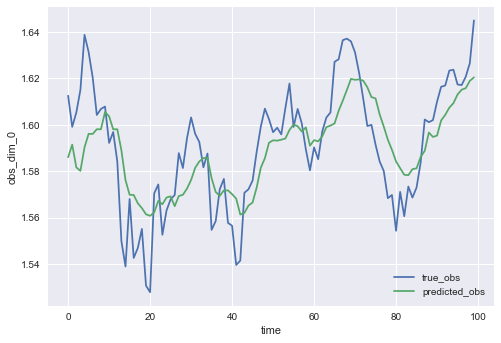

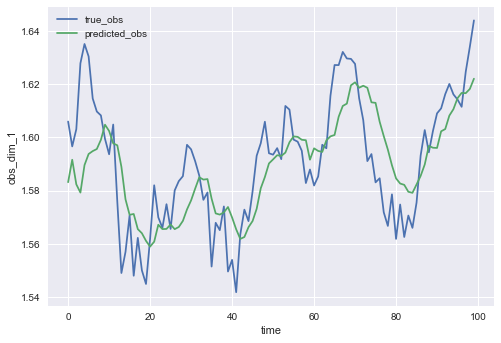

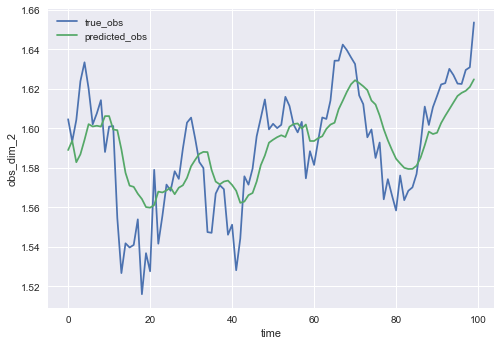

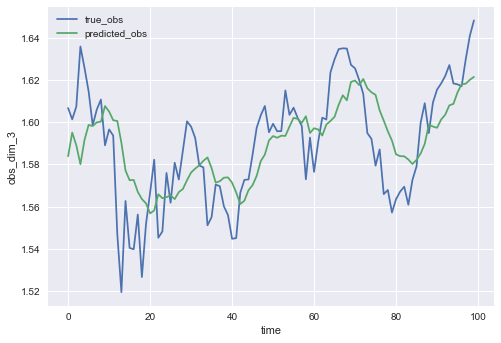

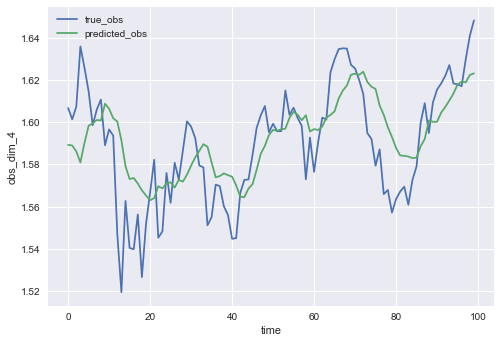

In [8]:
plot_expression(RLT_DIR,
                np.mean(prediction_val_test, axis=2)[0:1],
                obs_test[0:1],
                is_test=True,
                show=True)

As noticed, the bidirectional RNN successfully learn the initial distribution, and the predicted observation in the beginning becomes close to ground truth.

## Experiments
The followings are other experiments results shown with presaved plots.

### Stock
Though we have demonstrated our code with Dow Jones stock data above, we still want to show the experiments results with stock data. The reason is, similar to many deep networks, **the performance of our model depends on the selected random seed**. As a result, we trained our model with different random seeds and picked the one with best performance, and thus the code demonstration above may not have as good performance as results shown below.

The followings are some comparison between predicted observations and true observations using Dow Jones dataset:

<table>
<tr>
<td> <img src="experiments/dow_jones/False_1/obs_compare_test/obs_dim_0_idx_0.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/dow_jones/False_1/obs_compare_test/obs_dim_0_idx_3.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/dow_jones/False_1/obs_compare_test/obs_dim_0_idx_5.png" alt="Drawing" style="width: 300px;"/> </td>
</table>

<br>

As a quantitative evaluation, the final MSE between predicted observation and true observation is 0.00016 on testing dataset, decreased by 86% compared with not learning the initial state. As well,
* for 72% of the time, the prediction error in stock price change will be < 1%, increased by 10%.
* for 92% of the time, the prediction error in stock price change will be < 2%, increased by 6%.

We got similar results on Nasdaq Composite and Standard & Poor's 500 data. Due to limitation of space and time, we will not analysis them in detail here.

Results of Nasdaq Composite:

<table>
<tr>
<td> <img src="experiments/nasdaq/False_1/obs_compare_test/obs_dim_0_idx_6.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/nasdaq/False_1/obs_compare_test/obs_dim_0_idx_7.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/nasdaq/False_1/obs_compare_test/obs_dim_0_idx_8.png" alt="Drawing" style="width: 300px;"/> </td>
</table>

Results of Standard & Poor's 500:

<table>
<tr>
<td> <img src="experiments/sp_500/False_1/obs_compare_test/obs_dim_0_idx_9.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/sp_500/False_1/obs_compare_test/obs_dim_0_idx_10.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="experiments/sp_500/False_1/obs_compare_test/obs_dim_0_idx_11.png" alt="Drawing" style="width: 300px;"/> </td>
</table>

<br>

## Importance Weight Auto-Encoder (IWAE)

As you may notice in the hyperparameters part of the code, there is a variable called ```n_particles``` and when ```n_particles > 1```, the model will use IWAE rather than VAE. So what is difference between IWAE and VAE, and how will it affect the performance of our model?

IWAE is a followup of VAE. It uses the same architecture as VAE, with a recogition network $q_{\phi}(z|x^{(i)})$ and a generative network $p_{\theta}(x|z)$. As a reminder, the ELBO of VAE is as follows:

<img src="doc_imgs/VAE_ELBO.png" alt="Drawing" style="width: 450px"/>

Instead of sampling one hidden value $z_1$ from recogition network $q_{\phi}(z|x^{(i)})$, IWAE samples $k$ hidden values $z_1, \dots, z_k$ and uses the following ELBO.

<img src="doc_imgs/IWAE_ELBO.png" alt="Drawing" style="width: 450px"/>

Observe, when $k=1$, $\mathcal{L}_{IWAE} = \mathcal{L}_{VAE}$. When $k>1$, IWAE outperforms VAE by providing a tighter ELBO. It is proved that:

$$\log p(x) \ge \mathcal{L}_{IWAE,k+1} \ge \mathcal{L}_{IWAE,k}$$
<br>
$$\lim_{k \rightarrow \infty} \mathcal{L}_{IWAE,k} = \log p(x)$$

As a result, using IWAE and increase number of samples (```n_particles```) will improve the performance of our model. However, the computational resource needed increases linearly with the number of samples, and it is impossible for one to use infinite samples to achieve the optimal performance. <br>
Due to the limitation of time, we only finished a few experiments on some of the data.